## Importing Libraries and Dependencies

In [1]:
# Ignoring Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data sources and analysis
import pandas as pd
from yahoo_fin import stock_info as si
import numpy as np

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use("fivethirtyeight")
import seaborn as sns

# Portfolio Optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Get discrete allocation of each share per stock
# need to install this package by running the command through terminal            conda install -c conda-forge cvxopt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [3]:
## Reading the best performers from the Database
best_performers = pd.read_csv('best_performers.csv')
best_performers.head()

,Ticker,Returns Compared,Score
0,AAPL,6.63,97.285068
1,ABMD,9.40,98.868778
2,ACN,2.57,81.108597
3,ADBE,3.03,86.764706
4,ADP,2.14,73.755656


In [4]:
## Initializing the final_df DataFrame
final_df = pd.DataFrame(columns = ['Tickers', 'Latest_Price', 'Score', 'PE_Ratio','PEG_Ratio','SMA_150', 'SMA_200', '52_week_low', '52_week_high'])

In [5]:
# We have to drop the peg ratio from our conditions because it was missing for some of the tickers and was giving error
# We could have pulled the beta value and make a condition out of it but due ti limitation of time couldn'e do it
for ticker in best_performers['Ticker']:
    try:
        df = pd.read_csv(f'stock_data/{ticker}.csv', index_col = 0)
        moving_avg = [150, 200]
        for ma in moving_avg:
            df['SMA_'+str(ma)] = round(df['Adj Close'].rolling(window = int(ma)).mean(), 2)
        latest_price = df['Adj Close'][-1]
        pe_ratio = float(si.get_quote_table(ticker)['PE Ratio (TTM)'])
#         peg_ratio = float(si.get_stats_valuation(ticker)[1][4])
        moving_average_150 = df['SMA_150'][-1]
        moving_average_200 = df['SMA_200'][-1]
        low_52week = round(min(df['Low'][-(52*5):]), 2) # 5 days of trading times 52 week in a year
        high_52week = round(max(df['High'][-(52*5):]), 2)
        score = round(best_performers[best_performers['Ticker'] == ticker]['Score'].tolist()[0])
            
        # Conditions
        condition_1 = latest_price > moving_average_150 > moving_average_200
        condition_2 = latest_price >= (1.3 * low_52week)
        condition_3 = latest_price >= (0.75 * high_52week)
        condition_4 = pe_ratio < 40
#         condition_5 = peg_ratio < 2
            
        # Conditional
        if condition_1 and condition_4:            #condition_1 and condition_2 and condition_3 and 
            final_df = final_df.append({'Tickers': ticker,
                                        'Latest_Price': latest_price,
                                        'Score': score,
                                        'PE_Ratio': pe_ratio,
#                                         'PEG_Ratio': peg_ratio,
                                        'SMA_150': moving_average_150,
                                        'SMA_200': moving_average_200,
                                        '52_week_low': low_52week,
                                        '52_week_high': high_52week}, 
                                         ignore_index = True)
    
    except Exception as e:
        print(f"{e} for {ticker}")

In [6]:
final_df.sort_values(by = 'Score', ascending = False)
pd.set_option('display.max_columns', 10)
final_df.to_csv('portfolio/portfolio1-SMA-PE.csv')
final_df

   Tickers Latest_Price Score PE_Ratio PEG_Ratio  SMA_150  SMA_200  \
0     AAPL   172.139999    97     27.8       NaN   161.26   157.26   
1      ADP        238.5    74    36.01       NaN    218.4   215.58   
2     ANTM   514.659973    81    21.42       NaN    431.3   418.03   
3     AVGO   603.049988    99    34.08       NaN   563.62   540.35   
4      AZO  2155.590088    89    20.36       NaN  1875.57  1803.29   
5      BRO    73.400002    79    34.33       NaN    64.82    62.29   
6      CHD   103.419998    73    31.05       NaN    93.57    91.32   
7     CINF   136.990005    70      7.8       NaN   120.64   120.27   
8      CNC    88.559998    93    39.04       NaN    75.98    74.24   
9      CSX    34.740002    70    22.22       NaN    34.72    34.17   
10    CTAS    434.23999    94    39.38       NaN    408.1   402.56   
11      DE   409.459991    78    23.03       NaN   364.06   362.57   
12     DHR   299.660004    85    35.57       NaN   299.46    298.8   
13    DLTR   158.610

## Visualization

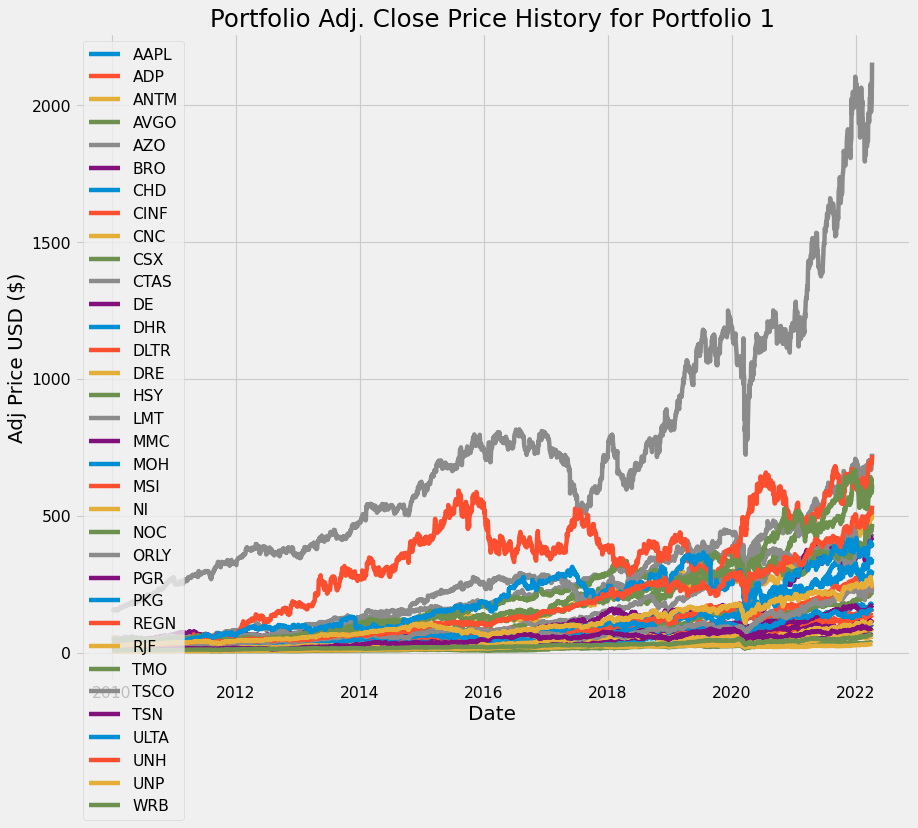

In [7]:
# Visually show the stock Portfolio
title = 'Portfolio Adj. Close Price History for Portfolio 1'

# Get the tickers for our Portfolio
my_stocks = final_df['Tickers']

# Create and plot the graph
plt.figure(figsize=(12, 10), dpi=80)
for ticker in my_stocks:
    df1 = pd.read_csv(f"stock_data/{ticker}.csv", index_col = [0], parse_dates = [0]) 
    plt.plot(df1['Adj Close'], label = ticker)

plt.title(title, fontsize = 22)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adj Price USD ($)', fontsize = 18)
plt.legend(my_stocks, loc = 'upper left')
plt.savefig('figures/portfolio_1.png')
plt.savefig('figures/portfolio_1.pdf')
plt.show()

# Calculating Returns

In [8]:
# show the daily simple returns
portfolio = pd.DataFrame()
portfolio_returns = pd.DataFrame()
for ticker in my_stocks:
    df2 = pd.read_csv(f"stock_data/{ticker}.csv", index_col = [0], parse_dates = [0]) 
    portfolio[ticker] = df2['Adj Close']
    portfolio_returns[ticker] = df2['Adj Close'].pct_change().dropna()
portfolio_returns.head()

,AAPL,ADP,ANTM,AVGO,AZO,...,TSN,ULTA,UNH,UNP,WRB
Date,,,,,,,,,,,
2010-01-06,-0.015906,-0.002348,0.016225,0.007895,-0.009380,...,0.050521,0.024520,0.009847,0.001508,0.002048
2010-01-07,-0.001849,-0.000471,0.037145,-0.006266,0.013270,...,0.017557,0.085328,0.038377,-0.008885,0.004087
2010-01-08,0.006649,-0.001413,0.004398,0.007357,-0.012842,...,-0.002251,0.035954,-0.009391,0.033885,-0.000814
2010-01-11,-0.008822,0.004479,0.005787,0.006260,0.001288,...,-0.013534,-0.015271,0.006728,-0.006614,0.002037
2010-01-12,-0.011375,-0.007041,-0.013217,-0.015034,-0.002187,...,-0.011433,-0.006579,-0.026428,-0.002959,0.004065


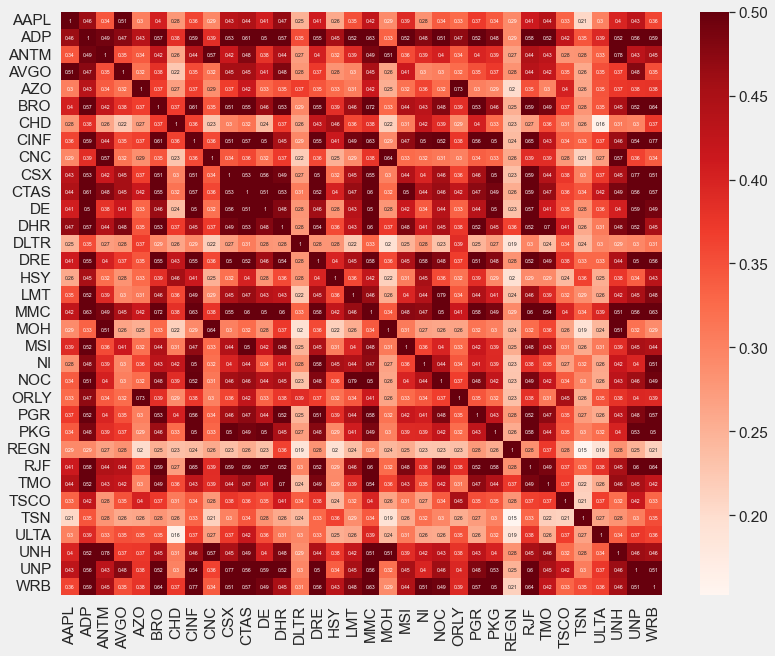

In [9]:
# Making a heat map representing the correlation matrix
plt.figure(figsize = (12, 10))
sns.set(font_scale = 1.4)
sns.heatmap(portfolio_returns.corr(), cmap = "Reds", annot = True, annot_kws = {"size": 5}, vmax = 0.5)
plt.savefig('figures/portfolio_1_hm.png')
plt.savefig('figures/portfolio_1_hm.pdf')
plt.show()

In [10]:
# Create and show the annualized covariance matrix
cov_matrix_annual = portfolio_returns.cov() * 252
cov_matrix_annual

,AAPL,ADP,ANTM,AVGO,AZO,...,TSN,ULTA,UNH,UNP,WRB
AAPL,0.078928,0.028358,0.027782,0.050442,0.019849,...,0.016629,0.033696,0.028652,0.030391,0.022009
ADP,0.028358,0.047545,0.030717,0.036609,0.021940,...,0.021642,0.034175,0.029246,0.030680,0.027831
ANTM,0.027782,0.030717,0.082431,0.035839,0.022697,...,0.023173,0.038165,0.057396,0.031311,0.027920
AVGO,0.050442,0.036609,0.035839,0.125022,0.026087,...,0.026333,0.049431,0.033697,0.042677,0.027044
AZO,0.019849,0.021940,0.022697,0.026087,0.053870,...,0.017466,0.032024,0.022279,0.022215,0.019138
BRO,0.024135,0.026649,0.025882,0.028723,0.018115,...,0.017088,0.029252,0.024447,0.027836,0.029453
CHD,0.015419,0.016519,0.014814,0.015688,0.012401,...,0.014975,0.012935,0.015617,0.014986,0.016032
CINF,0.025722,0.032633,0.031975,0.031828,0.021572,...,0.024153,0.037068,0.030028,0.034852,0.042122
CNC,0.030759,0.031310,0.060975,0.041534,0.024705,...,0.022916,0.040145,0.054459,0.034075,0.027455
CSX,0.034852,0.033134,0.034279,0.046021,0.024490,...,0.024808,0.042623,0.032870,0.055491,0.031691


In [12]:
# Calculate the portfolio variance
# weights = np.full((1, 30), 0.033)
weights = np.empty(len(final_df)); weights.fill(1/len(final_df))
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.028681280026725944

In [13]:
# Calculate portfolio Volatility aka Standard Deviation
port_volatility = np.sqrt(port_variance)
port_volatility

0.16935548419441854

In [14]:
# Calculate annual portfolio returns
port_simple_annual_return = np.sum(portfolio_returns.mean() * weights) * 252
port_simple_annual_return

0.24199228099827438

In [15]:
# Show the expected annual return, volatility (risk), and variance
percent_var = str(round(port_variance, 2) * 100) + '%'
percent_volatility = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(port_simple_annual_return, 2) * 100) + '%'

print('Expected annual return: '+ percent_ret)
print('Annual Volatility / Risk: '+ percent_volatility)
print('Annual Variance: '+ percent_var)

Expected annual return: 24.0%
Annual Volatility / Risk: 17.0%
Annual Variance: 3.0%


# Portfolio Optimization

In [16]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [17]:
# Portfolio Optimization

# Calculate the expected returns and the annualized samplecovariance matrix of asset returns
mu = expected_returns.mean_historical_return(portfolio)
S = risk_models.sample_cov(portfolio)

# Optimize for maximum sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('AAPL', 0.13216), ('ADP', 0.0), ('ANTM', 0.0), ('AVGO', 0.07379), ('AZO', 0.09874), ('BRO', 0.0), ('CHD', 0.13746), ('CINF', 0.0), ('CNC', 0.0), ('CSX', 0.0), ('CTAS', 0.06963), ('DE', 0.0), ('DHR', 0.0), ('DLTR', 0.0), ('DRE', 0.0), ('HSY', 0.0654), ('LMT', 0.0), ('MMC', 0.0), ('MOH', 0.0), ('MSI', 0.0), ('NI', 0.0), ('NOC', 0.06594), ('ORLY', 0.07854), ('PGR', 0.02313), ('PKG', 0.0), ('REGN', 0.06027), ('RJF', 0.0), ('TMO', 0.0), ('TSCO', 0.06508), ('TSN', 0.01127), ('ULTA', 0.0), ('UNH', 0.11858), ('UNP', 0.0), ('WRB', 0.0)])
Expected annual return: 26.1%
Annual volatility: 16.6%
Sharpe Ratio: 1.46


(0.2609219612730563, 0.16557201780097613, 1.4550886343769371)

In [18]:
# Get discrete allocation of each share per stock
# need to install this package by running the command through terminal            conda install -c conda-forge cvxopt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(portfolio)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 15000)

allocation, leftover = da.lp_portfolio()
print('Discrete Allocation: '+ str(allocation))
print('Funds Remaining: ${:.2f}'.format(leftover))

Discrete Allocation: {'AAPL': 11, 'AVGO': 2, 'AZO': 1, 'CHD': 19, 'CTAS': 2, 'HSY': 4, 'NOC': 2, 'ORLY': 2, 'PGR': 3, 'REGN': 1, 'TSCO': 4, 'UNH': 3}
Funds Remaining: $10.11


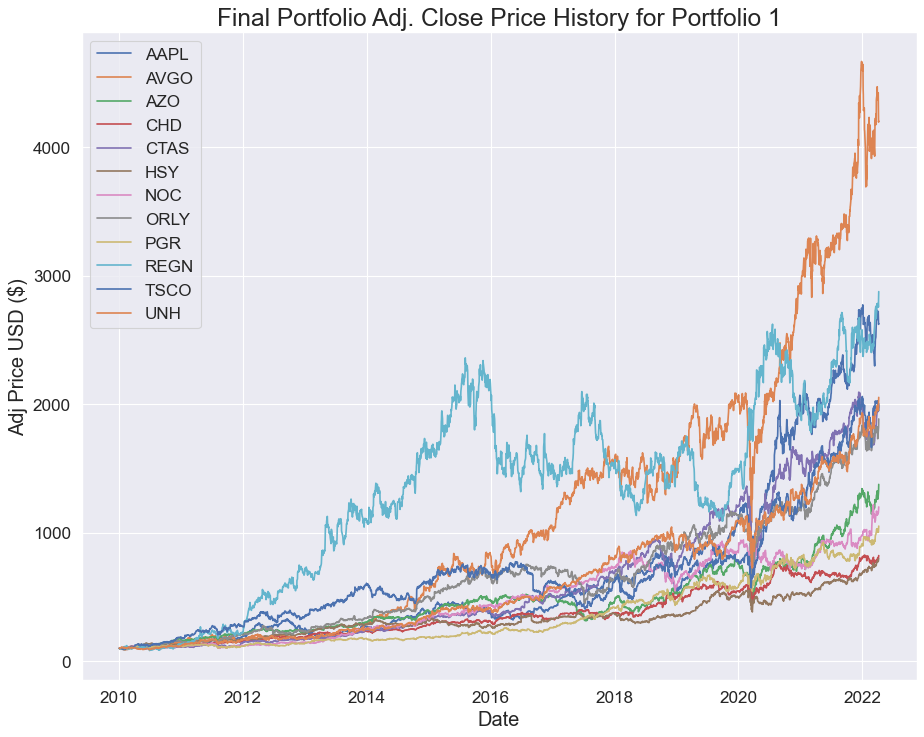

In [20]:
# Visually show the stock Portfolio
title = 'Final Portfolio Adj. Close Price History for Portfolio 1'

# Get the tickers for our Portfolio
stocks_to_invest = list()
for i in allocation.keys():
    stocks_to_invest.append(i)
stocks_to_invest

# Create and plot the graph
plt.figure(figsize=(12, 10), dpi=80)
for ticker in stocks_to_invest:
    df1 = pd.read_csv(f"stock_data/{ticker}.csv", index_col = [0], parse_dates = [0]) 
    plt.plot(df1['Normalized Adj Close'], label = ticker)

plt.title(title, fontsize = 22)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adj Price USD ($)', fontsize = 18)
plt.legend(stocks_to_invest, loc = 'upper left')
plt.savefig('figures/portfolio_1_optimized.png')
plt.savefig('figures/portfolio_1_optimized.pdf')
plt.show()

In [35]:
# Saving the Stock Allocation to csv
data_items = allocation.items()
data_list = list(data_items)
stocks_to_invest_with_allocation = pd.DataFrame(data_list, columns = ['Tickers', 'Allocation'])

In [38]:
stocks_to_invest_with_allocation.to_csv('portfolio/portfolio-1-optimized-stock-allocation.csv', index = None)

In [39]:
# show the daily simple returns
final_portfolio = pd.DataFrame()
final_portfolio_returns = pd.DataFrame()
for ticker in stocks_to_invest:
    df3 = pd.read_csv(f"stock_data/{ticker}.csv", index_col = [0], parse_dates = [0]) 
    final_portfolio[ticker] = df3['Adj Close']
    final_portfolio_returns[ticker] = df3['Adj Close'].pct_change().dropna()
final_portfolio_returns

,AAPL,AVGO,AZO,CHD,CTAS,...,ORLY,PGR,REGN,TSCO,UNH
Date,,,,,,,,,,,
2010-01-06,-0.015906,0.007895,-0.009380,0.004792,0.002656,...,-0.004409,-0.010017,-0.015139,-0.002084,0.009847
2010-01-07,-0.001849,-0.006266,0.013270,-0.011184,0.008706,...,-0.003126,-0.013491,-0.006068,0.013670,0.038377
2010-01-08,0.006649,0.007357,-0.012842,-0.002162,0.009756,...,-0.008884,0.009117,-0.008140,-0.000562,-0.009391
2010-01-11,-0.008822,0.006260,0.001288,-0.004334,-0.004088,...,0.005273,-0.025409,0.019286,-0.008058,0.006728
2010-01-12,-0.011375,-0.015034,-0.002187,0.025448,-0.013433,...,0.018883,0.002318,-0.013285,0.000378,-0.026428
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,-0.001718,-0.004288,-0.034271,0.019924,-0.003550,...,-0.025593,0.010527,-0.005140,-0.028538,0.005138
2022-04-04,0.023693,0.012552,0.021205,-0.005426,0.012598,...,0.029097,-0.009463,0.005152,0.004279,-0.005014
2022-04-05,-0.018942,-0.032653,0.012473,0.000893,0.005079,...,0.005300,0.001139,-0.009937,-0.013967,0.015176


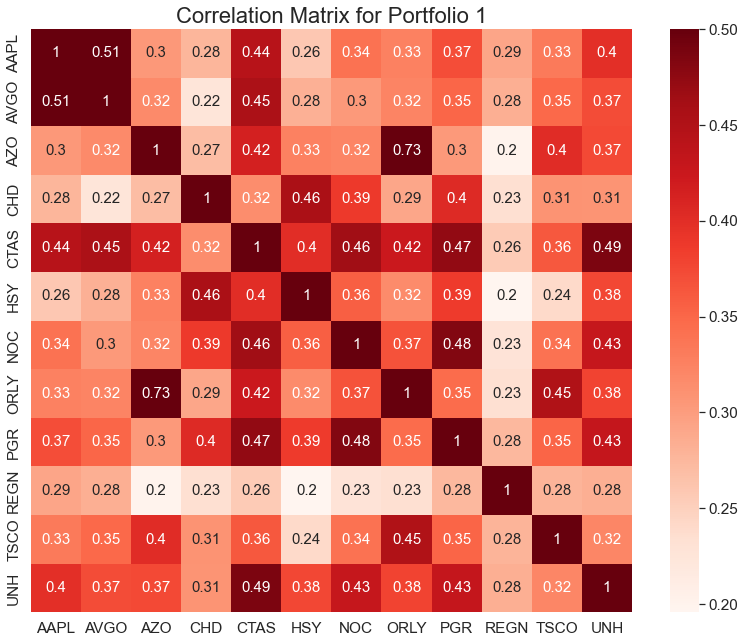

In [41]:
# Making a heat map representing the correlation matrix
title1 = "Correlation Matrix for Portfolio 1"

plt.figure(figsize = (12, 10))
sns.set(font_scale = 1.4)
sns.heatmap(final_portfolio_returns.corr(), cmap = "Reds", annot = True, annot_kws = {"size": 15}, vmax = 0.5)
plt.title(title1, fontsize = 22)
plt.savefig('figures/optimized_portfolio_1_hm.png')
plt.savefig('figures/optimized_portfolio_1_hm.pdf')
plt.show()